### Behaviorally, is there an increase in the probability of choosing a feature after choosing it and getting it correct?

In [23]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
from matplotlib import pyplot as plt
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
subject = "SA"

In [25]:
def get_stats(beh, feat, cond_filters):
    beh = behavioral_utils.get_belief_partitions(beh, feat, use_x=True)
    beh = behavioral_utils.get_feat_choice_label(beh, feat)

    beh = behavioral_utils.get_prev_choice_fbs(beh)
    beh = behavioral_utils.get_prev_feat_choice_label(beh, feat)

    beh = behavioral_utils.get_next_choice_fbs(beh)
    beh = behavioral_utils.get_next_feat_choice_label(beh, feat)
    res = []
    for cond in cond_filters:
        filt = cond_filters[cond]
        sub_beh = behavioral_utils.filter_behavior(beh, filt)
        if len(sub_beh) == 0:
            continue
        prev_chose_prob = len(sub_beh[sub_beh.PrevChoice == "Chose"]) / len(sub_beh)
        next_chose_prob = len(sub_beh[sub_beh.NextChoice == "Chose"]) / len(sub_beh)
        res.append({"cond": cond, "position": "prev", "prob": prev_chose_prob})
        res.append({"cond": cond, "position": "next", "prob": next_chose_prob})
    return pd.DataFrame(res)


def load_session_beh(row, subject):
    beh = behavioral_utils.get_valid_belief_beh_for_sub_sess(subject, row.session_name)
    beh["session"] = int(row.session_name)
    return beh

def get_all_beh(subject):
    valid_sessions = pd.read_pickle(SESSIONS_PATH.format(sub=subject))
    all_beh = pd.concat(valid_sessions.apply(lambda x: load_session_beh(x, subject), axis=1).values)
    return all_beh

In [26]:
all_beh = get_all_beh(subject)

### Interaction of choice, reward changes policy

/src/wcst_decode/utils/behavioral_utils.py:953: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beh["Choice"] = beh.apply(lambda x: "Chose" if x[FEATURE_TO_DIM[feat]] == feat else "Not Chose", axis=1)
/src/wcst_decode/utils/behavioral_utils.py:471: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beh["PrevResponse"] = beh.Response.shift()
/src/wcst_decode/utils/behavioral_utils.py:473: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

<Axes: xlabel='cond', ylabel='prob'>

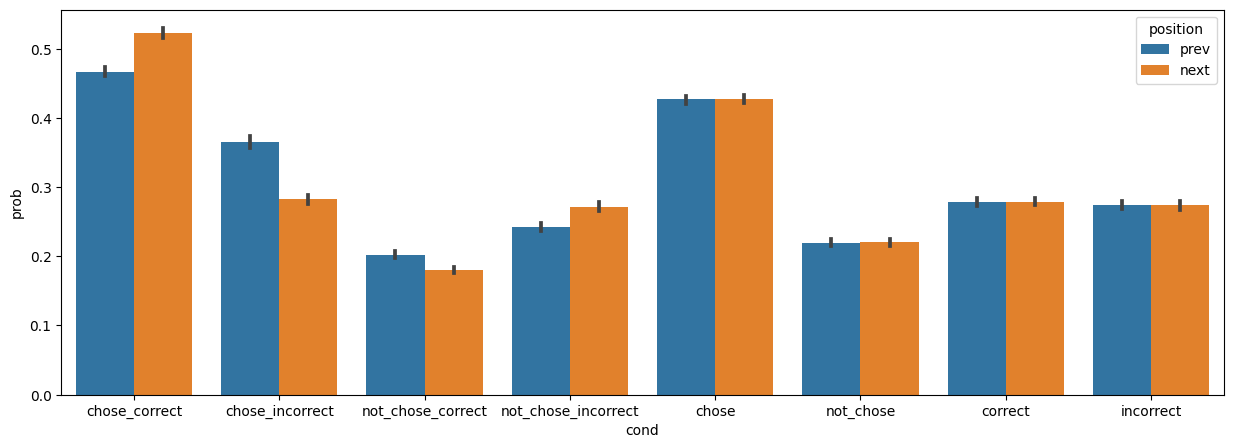

In [27]:
condition_filters = {
    "chose_correct": {"Choice": "Chose", "Response": "Correct"},
    "chose_incorrect": {"Choice": "Chose", "Response": "Incorrect"},
    "not_chose_correct": {"Choice": "Not Chose", "Response": "Correct"},
    "not_chose_incorrect":{"Choice": "Not Chose", "Response": "Incorrect"},
    "chose": {"Choice": "Chose"},
    "not_chose": {"Choice": "Not Chose"},
    "correct": {"Response": "Correct"},
    "incorrect": {"Response": "Incorrect"},
}

stats_res = []
FEATS_PATH = "/data/patrick_res/sessions/{sub}/feats_at_least_3blocks.pickle"
feat_sessions = pd.read_pickle(FEATS_PATH.format(sub=subject))
for i, row in feat_sessions.iterrows():
    for session in row.sessions:
        sess_beh = all_beh[all_beh.session == int(session)].copy()
        res = get_stats(sess_beh, row.feat, condition_filters)
        res["feat"] = row.feat
        res["session"] = session
        stats_res.append(res)
stats_res = pd.concat(stats_res)
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(stats_res, y="prob", x="cond", hue="position", ax=ax)

### change in policy dependent on belief partition (chose, correct)

/src/wcst_decode/utils/behavioral_utils.py:953: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beh["Choice"] = beh.apply(lambda x: "Chose" if x[FEATURE_TO_DIM[feat]] == feat else "Not Chose", axis=1)
/src/wcst_decode/utils/behavioral_utils.py:471: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beh["PrevResponse"] = beh.Response.shift()
/src/wcst_decode/utils/behavioral_utils.py:473: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

Text(0.5, 1.0, 'change in choice probabilities after feature is chosen, correct')

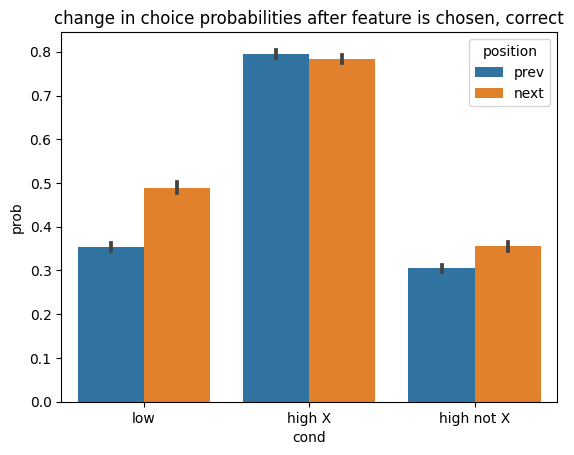

In [28]:
condition_filters = {
    "low": {"Choice": "Chose", "Response": "Correct", "BeliefPartition": "Low"},
    "high X": {"Choice": "Chose", "Response": "Correct", "BeliefPartition": "High X"},
    "high not X": {"Choice": "Chose", "Response": "Correct", "BeliefPartition": "High Not X"},
}

stats_res = []
FEATS_PATH = "/data/patrick_res/sessions/{sub}/feats_at_least_3blocks.pickle"
feat_sessions = pd.read_pickle(FEATS_PATH.format(sub=subject))
for i, row in feat_sessions.iterrows():
    for session in row.sessions:
        sess_beh = all_beh[all_beh.session == int(session)].copy()
        # print(row.feat)
        # print(session)
        res = get_stats(sess_beh, row.feat, condition_filters)
        res["feat"] = row.feat
        res["session"] = session
        stats_res.append(res)
stats_res = pd.concat(stats_res)
fig, ax = plt.subplots()
sns.barplot(stats_res, y="prob", x="cond", hue="position", ax=ax)
ax.set_title("change in choice probabilities after feature is chosen, correct")

### change in policy dependent on belief partition (chose, incorrect)

/src/wcst_decode/utils/behavioral_utils.py:953: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beh["Choice"] = beh.apply(lambda x: "Chose" if x[FEATURE_TO_DIM[feat]] == feat else "Not Chose", axis=1)
/src/wcst_decode/utils/behavioral_utils.py:471: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beh["PrevResponse"] = beh.Response.shift()
/src/wcst_decode/utils/behavioral_utils.py:473: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

Text(0.5, 1.0, 'change in choice probabilities after feature is chosen, incorrect')

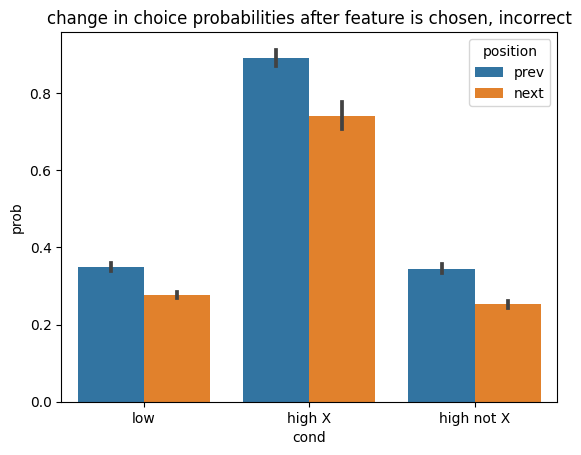

In [29]:
condition_filters = {
    "low": {"Choice": "Chose", "Response": "Incorrect", "BeliefPartition": "Low"},
    "high X": {"Choice": "Chose", "Response": "Incorrect", "BeliefPartition": "High X"},
    "high not X": {"Choice": "Chose", "Response": "Incorrect", "BeliefPartition": "High Not X"},
}

stats_res = []
FEATS_PATH = "/data/patrick_res/sessions/{sub}/feats_at_least_3blocks.pickle"
feat_sessions = pd.read_pickle(FEATS_PATH.format(sub=subject))
for i, row in feat_sessions.iterrows():
    for session in row.sessions:
        sess_beh = all_beh[all_beh.session == int(session)].copy()
        # print(row.feat)
        # print(session)
        res = get_stats(sess_beh, row.feat, condition_filters)
        res["feat"] = row.feat
        res["session"] = session
        stats_res.append(res)
stats_res = pd.concat(stats_res)
fig, ax = plt.subplots()
sns.barplot(stats_res, y="prob", x="cond", hue="position", ax=ax)
ax.set_title("change in choice probabilities after feature is chosen, incorrect")

### Scratch

In [74]:
# beh = all_beh[all_beh.session == 20190225]
# beh = behavioral_utils.get_belief_partitions(beh, "POLKADOT", use_x=True)
# POLKADOT
# 20190225

behavior_path = SESS_BEHAVIOR_PATH.format(
    sess_name=20190225,
    sub="BL"
)
beh = pd.read_csv(behavior_path)
beh = behavioral_utils.get_valid_trials(beh, "BL")


feature_selections = behavioral_utils.get_selection_features(beh)
beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")

In [75]:
beh[beh.CurrentRule == "POLKADOT"].BlockNumber.unique()

array([ 9, 15, 20])

In [79]:
beh[beh.BlockNumber == 20]

,TrialNumber,BlockNumber,TrialAfterRuleChange,TaskInterrupt,ConditionNumber,Response,ItemChosen,TrialType,CurrentRule,LastRule,...,Item1Pattern,Item2Shape,Item2Color,Item2Pattern,Item3Shape,Item3Color,Item3Pattern,Color,Shape,Pattern
682,690,20,0,NaN,4804,Incorrect,3.0,0,POLKADOT,ESCHER,...,RIPPLE,SQUARE,CYAN,ESCHER,TRIANGLE,GREEN,SWIRL,GREEN,TRIANGLE,SWIRL
683,691,20,1,NaN,5104,Incorrect,3.0,0,POLKADOT,ESCHER,...,RIPPLE,STAR,CYAN,ESCHER,CIRCLE,GREEN,SWIRL,GREEN,CIRCLE,SWIRL
684,693,20,3,NaN,4633,Correct,0.0,0,POLKADOT,ESCHER,...,RIPPLE,SQUARE,YELLOW,ESCHER,STAR,MAGENTA,SWIRL,CYAN,TRIANGLE,POLKADOT
685,694,20,4,NaN,4759,Incorrect,2.0,0,POLKADOT,ESCHER,...,RIPPLE,TRIANGLE,YELLOW,ESCHER,STAR,MAGENTA,SWIRL,YELLOW,TRIANGLE,ESCHER
686,695,20,5,NaN,5151,Incorrect,3.0,0,POLKADOT,ESCHER,...,RIPPLE,CIRCLE,YELLOW,ESCHER,TRIANGLE,CYAN,SWIRL,CYAN,TRIANGLE,SWIRL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,766,20,76,NaN,5097,Correct,0.0,0,POLKADOT,ESCHER,...,RIPPLE,TRIANGLE,GREEN,ESCHER,STAR,CYAN,SWIRL,MAGENTA,SQUARE,POLKADOT
750,767,20,77,NaN,5001,Correct,0.0,0,POLKADOT,ESCHER,...,RIPPLE,CIRCLE,GREEN,ESCHER,SQUARE,CYAN,SWIRL,YELLOW,STAR,POLKADOT
751,768,20,78,NaN,4984,Correct,0.0,0,POLKADOT,ESCHER,...,RIPPLE,SQUARE,CYAN,ESCHER,TRIANGLE,GREEN,SWIRL,YELLOW,STAR,POLKADOT
752,769,20,79,NaN,5162,Incorrect,1.0,0,POLKADOT,ESCHER,...,RIPPLE,STAR,CYAN,ESCHER,TRIANGLE,MAGENTA,SWIRL,YELLOW,CIRCLE,RIPPLE


In [77]:
beh[(beh.TrialNumber > 300) & (beh.TrialNumber < 350)][["Response", "CurrentRule", "ItemChosen", "Item0Pattern", "Item1Pattern", "Item2Pattern", "Item3Pattern"]]

,Response,CurrentRule,ItemChosen,Item0Pattern,Item1Pattern,Item2Pattern,Item3Pattern
293,Incorrect,POLKADOT,3.0,POLKADOT,RIPPLE,ESCHER,SWIRL
294,Incorrect,POLKADOT,3.0,POLKADOT,RIPPLE,ESCHER,SWIRL
295,Correct,POLKADOT,0.0,POLKADOT,RIPPLE,ESCHER,SWIRL
296,Incorrect,POLKADOT,3.0,POLKADOT,RIPPLE,ESCHER,SWIRL
297,Correct,POLKADOT,0.0,POLKADOT,RIPPLE,ESCHER,SWIRL
298,Correct,POLKADOT,0.0,POLKADOT,RIPPLE,ESCHER,SWIRL
299,Correct,POLKADOT,0.0,POLKADOT,RIPPLE,ESCHER,SWIRL
300,Correct,POLKADOT,0.0,POLKADOT,RIPPLE,ESCHER,SWIRL
301,Incorrect,POLKADOT,3.0,POLKADOT,RIPPLE,ESCHER,SWIRL
302,Incorrect,POLKADOT,3.0,POLKADOT,RIPPLE,ESCHER,SWIRL


In [80]:
beh[(beh.TrialNumber > 768) & (beh.TrialNumber < 775)][["Response", "CurrentRule", "ItemChosen", "Item0Pattern", "Item0Color", "Item2Pattern", "Item3Pattern"]]

,Response,CurrentRule,ItemChosen,Item0Pattern,Item0Color,Item2Pattern,Item3Pattern
752,Incorrect,POLKADOT,1.0,POLKADOT,GREEN,ESCHER,SWIRL
753,Correct,POLKADOT,0.0,POLKADOT,YELLOW,ESCHER,SWIRL


In [53]:
beh[(beh.BeliefPartition == "High X") & (beh.Response == "Incorrect") & (beh.Pattern == "POLKADOT")]

,TrialNumber,BlockNumber,TrialAfterRuleChange,TaskInterrupt,ConditionNumber,Response,ItemChosen,TrialType,CurrentRule,LastRule,...,PrevColor,PrevShape,PrevPattern,session,BeliefConf,BeliefPolicy,BeliefPartition,NextBeliefConf,NextBeliefPolicy,NextBeliefPartition


In [73]:
beh.groupby(["ItemChosen", "Response"]).TrialNumber.nunique()

ItemChosen  Response 
0.0         Correct      956
1.0         Incorrect    247
2.0         Incorrect    235
3.0         Incorrect    269
Name: TrialNumber, dtype: int64